Exp 1 - T Pyramid

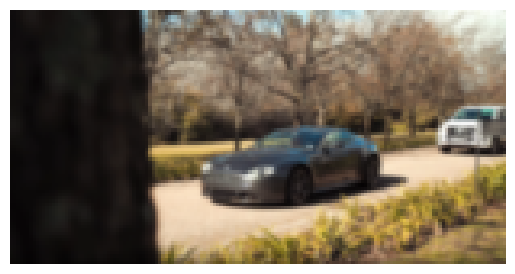

In [2]:
import cv2, numpy as np, matplotlib.pyplot as plt

def final_level(img, levels=4):
    p = img.astype(np.float32)
    for _ in range(levels - 1):
        p = cv2.GaussianBlur(p, (5, 5), 0)[::2, ::2]
    return p

img = cv2.imread('/content/Screenshot 2025-03-23 190404.png')
if img is None:
    print("Error: Could not read image")
    exit()

final_img = final_level(img)
plt.imshow(cv2.cvtColor(final_img.astype(np.uint8), cv2.COLOR_BGR2RGB) if final_img.ndim == 3 else final_img, cmap='gray')
plt.axis('off')
plt.show()


Exp *2* - Quad Tree Represenation

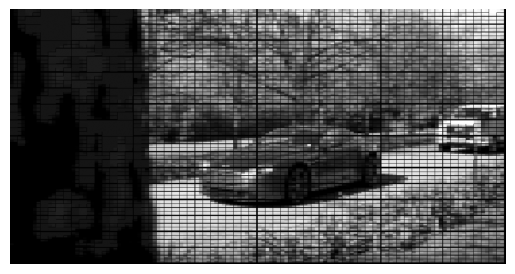

In [4]:
import cv2, numpy as np, matplotlib.pyplot as plt

def build(img, x, y, w, h, t=5, md=7, d=0):
    r = img[y:y+h, x:x+w]
    m, v = np.mean(r), np.var(r)
    n = {'x':x, 'y':y, 'w':w, 'h':h, 'd':d, 'c':[], 'l':True, 'm':m}
    if v > t and d < md and w > 1 and h > 1:
        nw, nh = w//2, h//2
        n['l'], n['c'] = False, [build(img, x+i*nw, y+j*nh, nw, nh, t, md, d+1) for j in range(2) for i in range(2)]
    return n

def draw(n, img):
    if n['l']: img[n['y']:n['y']+n['h'], n['x']:n['x']+n['w']] = n['m']
    else: [draw(c, img) for c in n['c']]

img = cv2.imread('/content/Screenshot 2025-03-23 190404.png', cv2.IMREAD_GRAYSCALE)
if img is None: exit('Error: Could not read image')

root = build(img, 0, 0, img.shape[1], img.shape[0])
seg_img = np.zeros_like(img)
draw(root, seg_img)

plt.imshow(seg_img, cmap='gray')
plt.axis('off')
plt.show()

Exp 3a - image steganography

In [8]:
import cv2,numpy as np

def to_bin(data):
    if isinstance(data,str): return ''.join([format(ord(i),"08b") for i in data])
    elif isinstance(data,bytes): return ''.join([format(i,"08b") for i in data])
    elif isinstance(data,np.ndarray): return [format(i,"08b") for i in data]

def encode(img_path,secret,out_path,delim="####"):
    img = cv2.imread(img_path)
    if img is None: raise ValueError("Image not found")
    n_bytes = img.shape[0]*img.shape[1]*3//8
    if len(secret) > n_bytes: raise ValueError("Error: Need bigger image or less data")

    bin_secret = to_bin(secret+delim)
    data_idx, data_len = 0, len(bin_secret)

    for row in img:
        for pixel in row:
            for c in range(3):
                if data_idx < data_len:
                    pixel[c] = int(bin(pixel[c])[:-1]+bin_secret[data_idx],2)
                    data_idx += 1

    cv2.imwrite(out_path,img)
    return True

def decode(img_path,delim="####"):
    img = cv2.imread(img_path)
    if img is None: raise ValueError("Image not found")

    bin_data, byte_count = "", 0
    max_bytes = 1000  # Safety limit

    for row in img:
        for pixel in row:
            for color in pixel:
                bin_data += bin(color)[-1]
                if len(bin_data) >= 8:
                    byte_count += 1
                    if byte_count > max_bytes: return "Not found"
                    if len(bin_data) % 8 == 0:
                        chars = ""
                        for i in range(0,len(bin_data),8):
                            chars += chr(int(bin_data[i:i+8],2))
                        if delim in chars: return chars.split(delim)[0]
            if byte_count > max_bytes: break
        if byte_count > max_bytes: break
    return "Not found"

if __name__ == "__main__":
    try:
        msg = "This is a secret message from Yash!"
        encode("/content/Screenshot 2025-03-23 190404.png",msg,"/content/encoded.png")
        print("Encoding completed")
        print(f"Decoded: {decode('/content/encoded.png')}")
    except Exception as e:
        print(f"Error: {e}")

Encoding completed
Decoded: This is a secret message from Yash!


Exp 3b - image watermarking

In [14]:
import cv2
import numpy as np

def watermark(img_path, output_path, text="Yashwanth"):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Create semi-transparent overlay
    overlay = img.copy()

    # Add text watermark
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = w/500
    thickness = 10
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]

    # Position at bottom right
    position = ((w - text_size[0])//2,( h - 100)//2)

    cv2.putText(overlay, text, position, font, font_scale, (0, 0, 0), thickness)

    # Blend with original
    alpha = 0.7
    cv2.addWeighted(overlay, alpha, img, 1-alpha, 0, img)

    cv2.imwrite(output_path, img)
    return output_path

# Usage
watermark("/content/Screenshot 2025-03-23 190404.png", "watermarked.jpg")

'watermarked.jpg'

Exp 4 - Object recognition visual inspection

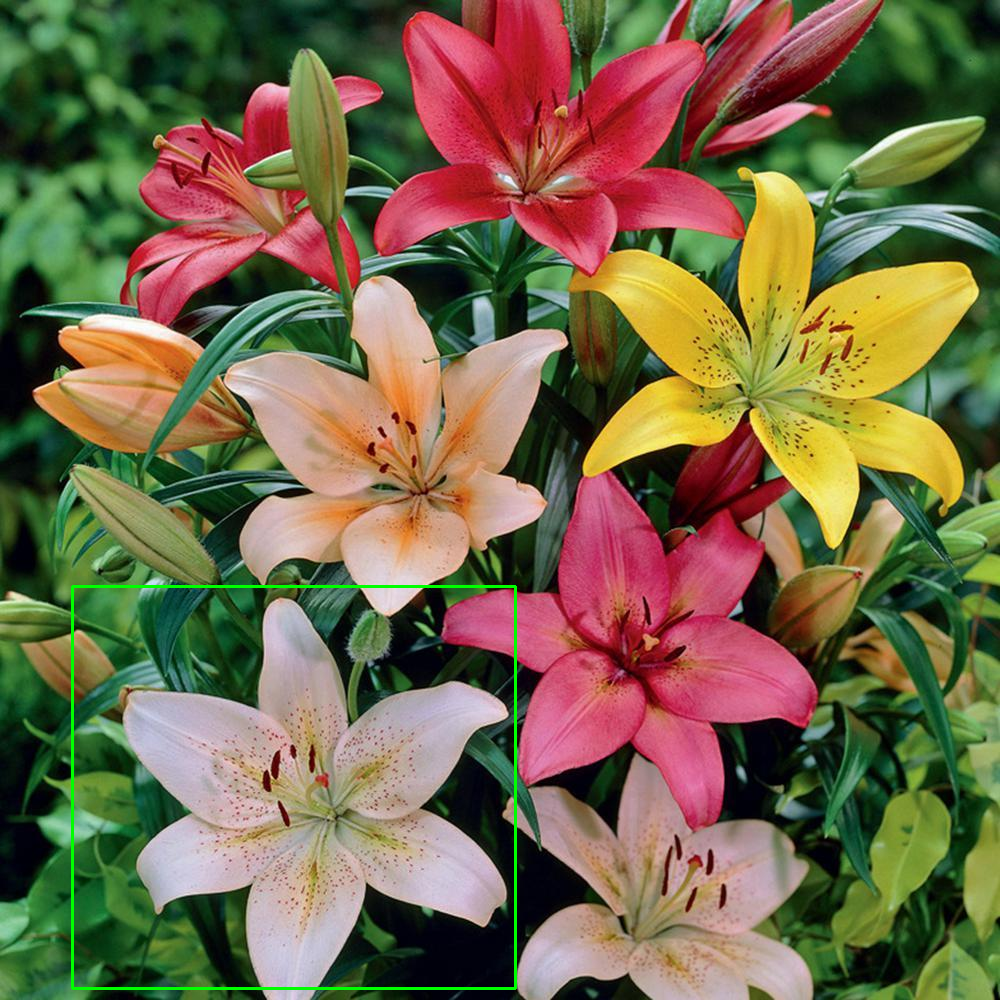

In [17]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
def extract_features(image, sift):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    return sift.detectAndCompute(gray, None)

def detect_objects(template, image):
    sift = cv2.SIFT_create()
    matcher = cv2.BFMatcher()

    kp1, des1 = extract_features(template, sift)
    kp2, des2 = extract_features(image, sift)
    if des1 is None or des2 is None:
        return image

    matches = matcher.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

    if len(good_matches) >= 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        h, w = template.shape[:2]
        corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(corners, H)
        cv2.polylines(image, [np.int32(transformed_corners)], True, (0, 255, 0), 2)

    return image

def main():
    template = cv2.imread('/content/Screenshot 2025-04-03 120044.png')
    image = cv2.imread('/content/lily-flowers.jpg')
    result = detect_objects(template, image)
    cv2_imshow(result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

Exp 5 - Geometric tranformation

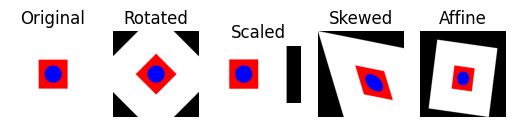

In [20]:
import cv2, numpy as np, matplotlib.pyplot as plt

def transform(img, M, size): return cv2.warpAffine(img, M, size)

img = np.ones((300, 300, 3), np.uint8) * 255
cv2.rectangle(img, (100, 100), (200, 200), (0, 0, 255), -1)
cv2.circle(img, (150, 150), 30, (255, 0, 0), -1)

h, w = img.shape[:2]
center, scale = (w//2, h//2), 1.0

# Transformations
rot = transform(img, cv2.getRotationMatrix2D(center, 45, scale), (w, h))
scale = transform(img, cv2.getRotationMatrix2D(center, 0, 1.5), (int(w*1.5), h))
skew = transform(img, np.float32([[1, 0.3, 0], [0.2, 1, 0]]), (w, h))
aff = transform(img, cv2.getAffineTransform(np.float32([[0,0],[w,0],[0,h]]), np.float32([[w*0.2,h*0.1],[w*0.9,h*0.2],[w*0.1,h*0.9]])), (w, h))

# Display
for i, (title, im) in enumerate(zip(["Original", "Rotated", "Scaled", "Skewed", "Affine"], [img, rot, scale, skew, aff])):
    plt.subplot(1, 5, i+1), plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)), plt.title(title), plt.axis('off')
plt.show()


Exp - 6 - Object detection and recognition

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

model = YOLO("yolov8n.pt")

image = cv2.imread("/content/images.jpg")

if image is None:
    print("Error: Image not found!")
else:
    results = model(image)

    for idx, result in enumerate(results):
        annotated_image = result.plot()

        cv2_imshow(annotated_image)

        output_filename = f"/content/annotated_output_{idx}.jpg"

        cv2.imwrite(output_filename, annotated_image)
        print(f"Saved output as {output_filename}")


Exp 7 - motion analysis by moving edges

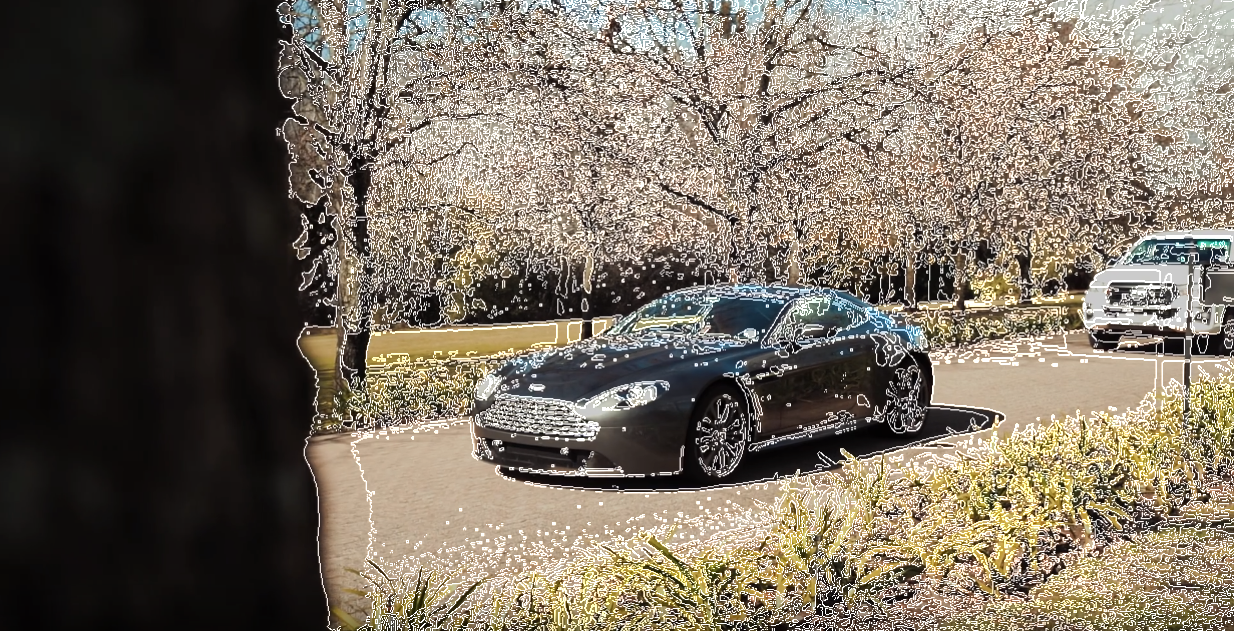

Saved output as /content/motion_edges.jpg


In [24]:
import cv2
from google.colab.patches import cv2_imshow

img1 = cv2.imread('/content/Screenshot 2025-03-23 190404.png')
img2 = cv2.imread('/content/Screenshot 2025-03-23 190427.png')

if img1 is None or img2 is None:
    print("Error: One of the images was not found!")
else:
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    if gray1.shape != gray2.shape:
        gray2 = cv2.resize(gray2, (gray1.shape[1], gray1.shape[0]))

    diff = cv2.absdiff(gray1, gray2)

    _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    edges = cv2.Canny(thresh, 50, 150)

    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    if edges_colored.shape != img2.shape:
        edges_colored = cv2.resize(edges_colored, (img2.shape[1], img2.shape[0]))

    combined = cv2.addWeighted(img2, 0.8, edges_colored, 1.0, 0)

    cv2_imshow(combined)

    output_filename = "/content/motion_edges.jpg"
    cv2.imwrite(output_filename, combined)
    print(f"Saved output as {output_filename}")

Exp 8 - ADAS Signboard

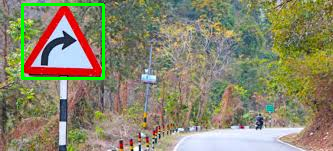

In [48]:
import cv2, numpy as np
from google.colab.patches import cv2_imshow

# Load image (make sure the image path is correct)
img = cv2.imread('/content/images.jpg')
if img is None:
    raise FileNotFoundError("Image file not found. Please check the file path.")

# Convert image to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Create masks for red (adjust thresholds as needed)
mask1 = cv2.inRange(hsv, (0, 100, 100), (10, 255, 255))
mask2 = cv2.inRange(hsv, (160, 100, 100), (179, 255, 255))
mask = mask1 | mask2

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes on sufficiently large contours
for cnt in contours:
    if cv2.contourArea(cnt) > 1000:  # filter out small contours
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result using cv2_imshow
cv2_imshow(img)


Exp - 9 - face detection

In [ ]:
!pip install deepface

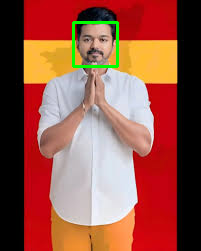

In [44]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread('/content/download.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
for (x, y, w, h) in face_cascade.detectMultiScale(gray, 1.1, 4):
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
cv2_imshow(img)
